In [1]:
import pandas as pd
from scipy.io import wavfile
import librosa
import numpy as np  
import os
import resampy
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA

In [2]:
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [3]:
DATASET_PATH = r"C:\Users\Acer\OneDrive\Desktop\projects\Gender_voice_recogintion\gender-recognition-by-voiceoriginal\data"

# Function to extract MFCC features from audio
def extract_features(file_path, max_pad_len=174):
    try:
        audio, sample_rate = librosa.load(file_path)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        if pad_width > 0:
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_pad_len]
        return mfccs.flatten()
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Prepare dataset
data = []
labels = []

for label in ['male', 'female']:
    folder = os.path.join(DATASET_PATH, label)
    for filename in os.listdir(folder):
        if filename.endswith(".wav"):
            file_path = os.path.join(folder, filename)
            features = extract_features(file_path)
            if features is not None:
                data.append(features)
                labels.append(label)

# Convert to DataFrame
X = np.array(data)
y = np.array(labels)

c:\Users\Acer\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [146]:
X.shape

(16148, 6960)

In [4]:
y

array(['male', 'male', 'male', ..., 'female', 'female', 'female'],
      dtype='<U6')

In [5]:
pca = PCA(n_components=230)
X_pca = pca.fit_transform(X)
print(X_pca[:230])

[[ -205.0046      483.53024    -471.5256    ...    47.298466
    -36.382168    -35.0711   ]
 [ -322.17526     907.521       -39.6563    ...    58.65392
    -40.862377     17.283485 ]
 [ 1585.0691     -260.58487    -854.1281    ...   -21.427614
    -77.20344      70.23717  ]
 ...
 [-1277.8684     -228.40462     310.85037   ...    31.960821
     52.83254      59.827553 ]
 [-1181.066       -82.14386     455.68372   ...   -20.00055
     23.823196     -7.3884068]
 [-1124.7352       30.091757    584.3731    ...  -107.96748
     20.962872     50.230293 ]]


In [159]:
y.shape

(16148,)

In [6]:
print("Explained variance:", pca.explained_variance_ratio_)
print("Cumulative:", np.cumsum(pca.explained_variance_ratio_))

Explained variance: [0.26011163 0.08112695 0.04223498 0.02857753 0.02334298 0.02047252
 0.01797502 0.01606919 0.0143866  0.01347488 0.01266479 0.01127697
 0.01003385 0.00981004 0.00935762 0.00850494 0.00772661 0.00723174
 0.00689766 0.00661968 0.00628046 0.00612645 0.00595275 0.0057297
 0.00555088 0.00533188 0.00515276 0.00500756 0.00484885 0.00459268
 0.00452471 0.00434937 0.00418422 0.00408192 0.00393611 0.00388124
 0.00378296 0.00370652 0.00369223 0.00361691 0.00350297 0.00346706
 0.00340723 0.00335416 0.0032716  0.00322145 0.00318306 0.00306598
 0.00303825 0.00290541 0.00288816 0.0028056  0.00274979 0.00269193
 0.0026351  0.00254636 0.00252904 0.00248529 0.00241985 0.00237608
 0.00228532 0.00225373 0.00221803 0.00217954 0.00214298 0.00210881
 0.00206824 0.00201031 0.00199916 0.00190586 0.00189534 0.00186973
 0.00180547 0.00178467 0.00176995 0.00171251 0.00167121 0.00164656
 0.001616   0.00158754 0.00156048 0.0015589  0.00150568 0.00148676
 0.00145114 0.00143989 0.00138717 0.0013502

In [8]:
y_binary = np.where(y== "female", 0,1)
y_binary

array([1, 1, 1, ..., 0, 0, 0])

In [9]:
y_binary.shape
X_pca.shape

(16148, 230)

In [10]:
unique, counts = np.unique(y_binary,return_counts=True)
unique,counts

(array([0, 1]), array([ 5768, 10380], dtype=int64))

<BarContainer object of 2 artists>

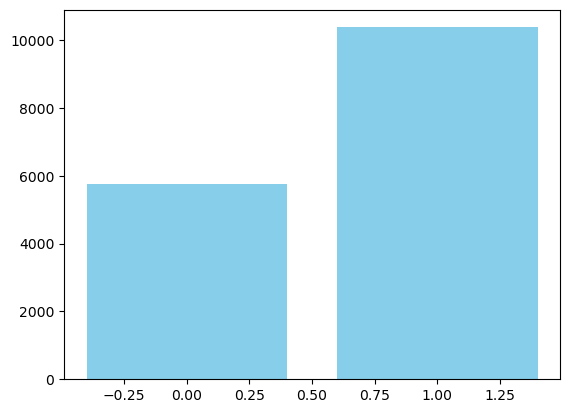

In [11]:
import matplotlib.pyplot as plt
plt.bar(unique, counts, color='skyblue')

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_binary, test_size=0.2, random_state=42)
unique, counts = np.unique(y_test,return_counts=True)
counts

array([1116, 2114], dtype=int64)

In [111]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(objective='binary:logistic',
                              eval_metric='logloss',
                              use_label_encoder=False, # Suppress future warning
                              n_estimators=100,        # Number of boosting rounds
                              learning_rate=0.1,       # Step size shrinkage
                              max_depth=5,             # Maximum depth of a tree
                              subsample=0.8,           # Subsample ratio of the training instance
                              colsample_bytree=0.8,    # Subsample ratio of columns when constructing each tree
                              gamma=0.1,               # Minimum loss reduction required to make a further partition
                              random_state=42)


In [113]:
param_grid = {
    'n_estimators': [100],
    'max_depth': [10],
    'learning_rate': [0.1],
    'scale_pos_weight': [1.91]
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    param_grid=param_grid,
    cv=3,
    n_jobs=1,
    verbose=2
)

grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END learning_rate=0.1, max_depth=10, n_estimators=100, scale_pos_weight=1.91; total time=   9.6s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=100, scale_pos_weight=1.91; total time=   7.4s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=100, scale_pos_weight=1.91; total time=   8.1s


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=1,
             param_grid={'learning_rate': [0.1], 'max_depth': [10],
                         'n_estimators': [100], 'scale_pos_weight': [1.91]},
             verbose=2)

In [114]:
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


Best Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'scale_pos_weight': 1.91}


In [115]:
from sklearn.metrics import classification_report

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.94      0.95      1116
           1       0.97      0.98      0.98      2114

    accuracy                           0.97      3230
   macro avg       0.97      0.96      0.97      3230
weighted avg       0.97      0.97      0.97      3230



In [140]:
import sounddevice as sd
from scipy.io.wavfile import write


fs = 44100  # Sampling rate
seconds = 5  # Duration of recording

print("Recording...")
recording = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
sd.wait()
write("my_voice.wav", fs, recording)
print("Recording saved as my_voice.wav")


Recording...
Recording saved as my_voice.wav


In [ ]:
# Load new audio
audio, sr = librosa.load(r"my_voice.wav")


# Extract MFCC features with same config used during training
mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
pad_width = 174 - mfcc.shape[1]
if pad_width > 0:
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
else:
    mfcc = mfcc[:, :174]
    


energy_threshold=0.01
duration_threshold=0.5
    # Check overall energy level
energy = np.sqrt(np.mean(audio**2))

if energy < energy_threshold:
    print("Silence")
else:
    
    pitches, magnitudes = librosa.piptrack(y=audio, sr=sr)
    pitch_values = pitches[magnitudes > np.median(magnitudes)]
    avg_pitch = np.mean(pitch_values)
    if avg_pitch < 50 or avg_pitch > 300:
        print("Not a Human")
        
    else:
    
        z = mfcc.flatten().reshape(1, -1)  # shape: (1, 6960)

        z=z.reshape(1, -1)

        z_pca = pca.transform(z)
        output=grid_search.predict(z_pca) 
        if output==1:
            print("It's male voice")
        else:
            print("Its female voice")
        
    
        


        

Not a Human
